In [1]:
import requests
import csv
import os
import pickle
import pandas as pd
import numpy as np
from zipfile import ZipFile
from matplotlib import pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
class F1Stats:
    
    zipfile=None
    cachefile=None
    dfs=None
    test={"A":"a", "B":"b"}
    # Geleend van FastF1
    driver_colors = {
        "BOT": "#900000", "ZHO": "#500000", "GAS": "#2b4562", "TSU": "#356cac", "ALO": "#0090ff", "OCO": "#70c2ff",
        "VET": "#006f62", "STR": "#25a617", "HUL": "#2f9b90", "LEC": "#dc0000", "SAI": "#ff8181", 
        "MAG": "#aaaaaa", "MSC": "#cacaca", "RIC": "#ff8700", "NOR": "#eeb370", "HAM": "#00d2be", "RUS": "#24ffff", 
        "VER": "#0600ef", "PER": "#716de2", "ALB": "#005aff", "LAT": "#012564"
    }
    
    points = [0, 25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    
    def __init__(self, zipdir='f1db_csv', zipfile='f1db.zip', cachefile='f1stats.pcl'):
        self.zipfile = os.path.join(zipdir, zipfile)
        self.cachefile = cachefile

    def download_data(self):
        url = 'http://ergast.com/downloads/f1db_csv.zip'
        r = requests.get(url, allow_redirects=True)
        open(self.zipfile, 'wb').write(r.content)
        # Open the zipfile
        zip_file = ZipFile(self.zipfile)
        # and read all files into a dictionary
        # key is filename (without .csv extension
        self.dfs = {text_file.filename[:-4]: pd.read_csv(zip_file.open(text_file.filename)).replace('\\N', '') \
                    for text_file in zip_file.infolist() if text_file.filename.endswith('.csv')} 
        print(self.dfs.keys())
        
    def save_data(self):
        with open(self.cachefile, 'wb') as handle:
            pickle.dump(self.dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    def load_data(self):
        with open(self.cachefile, 'rb') as handle:
            self.dfs = pickle.load(handle)
            
    def initialize(self, download=True):
        if download:
            self.download_data()
            self.cleanup_data()
            self.save_data()
        else:
            self.load_data()        

    def __column_strip_string(self, dfname, columnnames):
        for c in columnnames:
            self.dfs[dfname][c] = self.dfs[dfname][c].str.strip()

    def __column_to_int(self, dfname, columnnames, default=0):
        for c in columnnames:
            self.dfs[dfname][c] = self.dfs[dfname][c].replace('', default).astype(int)

    def __column_to_float(self, dfname, columnnames, default=0):
        for c in columnnames:
            self.dfs[dfname][c] = self.dfs[dfname][c].replace('', default).astype(float)

    def __column_to_datetime(self, dfname, datecolumn, timecolumn=None, newcolumn=None, onerror='ignore'):
        dropcolumns=[]
        if timecolumn:
            self.dfs[dfname][datecolumn] = self.dfs[dfname][datecolumn] + ' ' + self.dfs[dfname][timecolumn]
            dropcolumns.extend([timecolumn])
        targetcolumn = datecolumn
        if newcolumn:
            targetcolumn = newcolumn
            dropcolumns.extend([datecolumn])
        self.dfs[dfname][targetcolumn] = pd.to_datetime(self.dfs[dfname][datecolumn], errors=onerror)
        self.__drop_columns(dfname, dropcolumns)

    def __column_to_time(self, dfname, datecolumn, timecolumn=None, newcolumn=None, onerror='ignore'):
        self.__column_to_datetime(dfname, datecolumn, timecolumn, newcolumn, onerror)
        targetcolumn = datecolumn
        if newcolumn: targetcolumn = newcolumn
        self.dfs[dfname][targetcolumn] = self.dfs[dfname][targetcolumn].dt.time

    def __column_to_date(self, dfname, datecolumn, timecolumn=None, newcolumn=None, onerror='ignore'):
        self.__column_to_datetime(dfname, datecolumn, timecolumn, newcolumn, onerror)
        targetcolumn = datecolumn
        if newcolumn: targetcolumn = newcolumn
        self.dfs[dfname][targetcolumn] = self.dfs[dfname][targetcolumn].dt.date
        
    def __drop_columns(self, dfname, dropcolumns):
        self.dfs[dfname] = self.dfs[dfname].drop(columns=dropcolumns)
        
    def cleanup_data(self):
        # Races
        self.__column_strip_string("races", ["name"])
        self.__column_to_datetime("races", "date", "time")
        self.__column_to_datetime("races", "fp1_date", "fp1_time", "fp1")
        self.__column_to_datetime("races", "fp2_date", "fp2_time", "fp2")
        self.__column_to_datetime("races", "fp3_date", "fp3_time", "fp3")
        self.__column_to_datetime("races", "quali_date", "quali_time", "quali")
        self.__column_to_datetime("races", "sprint_date", "sprint_time", "sprint")
        self.__drop_columns("races", ["url"])
        # Results
        self.__column_to_int("results", ['position', 'number', 'fastestLap', 'rank'])
        self.__column_to_float("results", ['fastestLapSpeed'])
        self.__column_strip_string("results", ["positionText"])
        self.__column_to_time("results", "fastestLapTime")
        # Drivers
        self.__column_to_int("drivers", ['number'])
        self.__column_strip_string("drivers", ['driverRef', 'code', 'forename', 'surname', 'nationality'])
        self.__column_to_date("drivers", "dob")
        self.dfs['drivers']['name'] = self.dfs['drivers']['forename'] + ' ' + self.dfs['drivers']['surname']
        self.__drop_columns('drivers', ['url'])
        # Constructors
        self.__column_strip_string("constructors", ['constructorRef', 'name', 'nationality'])
        self.__drop_columns("constructors", ['url'])
        # Qualifying
        self.__column_to_time("qualifying", "q1")
        self.__column_to_time("qualifying", "q2")
        self.__column_to_time("qualifying", "q3")
        # Sprint results
        self.__column_to_int("sprint_results", ['position', 'number', 'fastestLap'])
        self.__column_strip_string("sprint_results", ["positionText"])
        self.__column_to_time("sprint_results", "fastestLapTime")
        # Driver standings
        self.__column_strip_string("driver_standings", ['positionText'])
        # Constructor standings
        self.__column_strip_string("constructor_standings", ['positionText'])
        # Lap times
        self.__column_to_time("lap_times", "time", onerror='coerce')
        # Pit stops
        self.__column_to_time("pit_stops", "time", onerror='coerce')

    def horizontal_barplot(self, df, rowcount, sort_value, sort_ascending, xcolumn, ycolumn, title='', 
                           xlabel='', ylabel='', invert_yaxis=True):
        fig, ax = plt.subplots(figsize=(15,8))
        plot_data = df.sort_values(sort_value, ascending=sort_ascending)[:rowcount]
        rects = ax.barh(plot_data[xcolumn], plot_data[ycolumn])

        for rect in rects:
            yloc = rect.get_y() + rect.get_height() / 2
            label = ax.annotate(str(rect.get_width()), xy=(rect.get_width(), yloc), xytext=(5, 0),
                                textcoords="offset points",
                                ha="left", va='center')
        if invert_yaxis: ax.invert_yaxis()

        ax.set_title(title)
        ax.set_xlabel(xlabel)    
        ax.set_ylabel(ylabel)   


    def horizontal_driver_lines_plot(self, df, xcolumn, ycolumn, invert_yaxis=False, 
                                     title = '', xlabel='', ylabel='', 
                                     ymin=None, ymax=None):
        fig, ax = plt.subplots(figsize=(15,10))
        drivers = df['code'].unique()
        for driver in drivers:
            df[df.code == driver].plot(xcolumn, ycolumn, ax=ax, label=driver, 
                                       color=self.get_driver_color(driver))
        ax.get_legend().remove()
        if invert_yaxis: ax.invert_yaxis()
        if ymin: 
          ax.set_ylim(ymin, ymax)
        else:
            ymax = int(df[ycolumn].max())+1
            if ymax < 50: ax.set_yticks(range(1, ymax, 1))
        xmax = int(df[xcolumn].max())+1
        ax.set_xticks(range(1, xmax, 2))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)

        for line, name in zip(ax.lines, drivers):
            y = line.get_ydata()[-1]
            x = line.get_xdata()[-1]
            text = ax.annotate(name, xy=(x + 0.1, y), xytext=(0, 0), 
                               color=line.get_color(), textcoords="offset points")

    def get_table(self, table):
        return self.dfs[table].copy()

    def get_race_results(self, year=None):
        raceresults = pd.merge(self.dfs['results'][['resultId', 'raceId', 'driverId', 'constructorId', 
                                                    'grid','position', 'positionText']], 
                               self.dfs['races'][['raceId', 'year', 'round', 'name', 'date']]. \
                                    rename(columns={'name': 'race'}))
        raceresults = pd.merge(raceresults,
                               self.dfs['drivers'][['driverId', 'number', 'name', 'code']]. \
                                    rename(columns={'name': 'driver'}))
        raceresults = pd.merge(raceresults,
                               self.dfs['constructors'][['constructorId', 'name']]. \
                                    rename(columns={'name': 'constructor'}))
        raceresults = raceresults.sort_values(['year', 'round', 'position'])
        raceresults['points'] = raceresults['position'].apply(lambda x: self.points[x])
        if year: raceresults =raceresults[raceresults['year'] == year]
        return raceresults.drop(columns=['resultId']).copy()

    def get_winners(self):
        winners = self.get_race_results()
        return winners[winners.position == 1].copy()

    def get_quali_results(self, year=None):
        qualiresults = \
            pd.merge(
                     pd.merge(pd.merge(self.dfs['qualifying'][['qualifyId', 'raceId', 'driverId', 'constructorId', 
                                                            'position']], 
                                       self.dfs['races'][['raceId', 'year', 'round', 'name', 'date']]. \
                                               rename(columns={'name': 'race'})),
                              self.dfs['drivers'][['driverId', 'number', 'name']]. \
                                      rename(columns={'name': 'driver'})),
                     self.dfs['constructors'][['constructorId', 'name']].rename(columns={'name': 'constructor'})
                    )
        qualiresults = qualiresults.sort_values(['year', 'round', 'position'])
        if year: qualiresults = qualiresults[qualiresults['year'] == year]
        return qualiresults.drop(columns=['qualifyId']).copy()

    def get_pole_sitters(self):
        poles = self.get_quali_results()
        return poles[poles.position ==1]

    def get_dnfs(self):
        dnfs = self.get_race_results()
        return dnfs[~dnfs['positionText'].str.isnumeric()].copy()
    
    def get_wdc_standing(self, year=None):
        standings = \
           self.dfs["driver_standings"]. \
            merge(self.dfs["races"][['raceId', 'year', 'round', 'name']].rename(columns={'name':'race'}), 
                  on='raceId') .\
            merge(self.dfs["drivers"][['driverId', 'name', 'code']])
        return standings[standings.year == year].copy() if year else standings.copy()

    def get_wcc_standing(self, year=None):
        standings = \
            stats.dfs["constructor_standings"]. \
                merge(stats.dfs["races"][['raceId', 'year', 'round', 'name']].rename(columns={'name':'race'}),
                      on='raceId') .\
                merge(stats.dfs["constructors"][['constructorId', 'name']])    
        return standings[standings.year == year].copy() if year else standings.copy()
    
    
    def get_wdc_champions(self):
        standings = self.get_wdc_standing()
        champions = standings[['year', 'round']].groupby('year').max().reset_index()
        champions['position'] = 1
        champions = champions.merge(
                        standings[['year', 'round', 'position', 'driverId', 'name', 'code', 'points', 'wins']])
        champions['perc_win'] =  (champions['wins'] / champions['round'] * 1000).astype(int) / 10
        return champions.copy()
    
    def get_laps_for_race(self, year, race):
        races = self.dfs['races'][self.dfs['races']['year'] == year]
        if isinstance(race,int):
            races = races[races["round"] == race]
        else:
            races = races[races["name"].str.contains(race)]
        raceID = races.iloc[0]['raceId']
        laps = self.dfs['lap_times'][self.dfs['lap_times']['raceId'] == raceID]

        # Add starting grid als lap 0 (position 0 means start from pit)
        grid = stats.dfs['results'][(stats.dfs['results']['raceId'] == raceID)][['raceId', 'driverId', 'grid']].rename(columns={'grid': 'position'})
        grid[['lap', 'milliseconds']] = (0,0)
        grid['position'] = grid['position'].replace(0, grid['position'].max()+1)
        laps = laps.append(grid)        

        laps = laps.merge(self.dfs["drivers"][['driverId', 'name', 'code']])
        laps = laps.merge(self.dfs['races'][['raceId', 'name']].rename(columns={'name':'event'}), on='raceId')
        
        return laps.sort_values(['driverId', 'lap']).copy()
    
    def get_driver_color(self, code):
        if code in set(self.dfs['drivers']['driverId'].unique()): # conver ID to code if required
            code = self.dfs['drivers'][self.dfs['drivers']['driverId'] == code]['code'].values[0]
        if code in self.driver_colors:
            return self.driver_colors[code]
        else:
            return "#000000"
        
    def info(self, methods=True, tables=True):
        if methods:
            methodList = []
            for method_name in dir(F1Stats):
                if not method_name.startswith('_'):
                    if callable(getattr(F1Stats, method_name)):
                        methodList.append(str(method_name))
            print('Methods')
            print('=======')
            for m in methodList:
                print(m)
            print()
        if tables:
            print('Tables')
            print('======')
            for key in stats.dfs.keys():
                print('{} '.format(key))
                for clm in stats.dfs[key].columns:
                    print('   {:22s}  - {}'.format(clm, stats.dfs[key][clm].dtype))

stats = F1Stats()
stats.initialize(download=False)
stats.dfs.keys()
stats.info(methods=True, tables=False)

Methods
cleanup_data
download_data
get_dnfs
get_driver_color
get_laps_for_race
get_pole_sitters
get_quali_results
get_race_results
get_table
get_wcc_standing
get_wdc_champions
get_wdc_standing
get_winners
horizontal_barplot
horizontal_driver_lines_plot
info
initialize
load_data
save_data



In [4]:
# # Get required dataframes
# races = stats.get_table("races")
# drivers = stats.get_table("drivers")
# constructors = stats.get_table("constructors")

# results = stats.get_table("results")
# constructor_results = stats.get_table("constructor_results")
# qualifying = stats.get_table("qualifying")
# sprint_results = stats.get_table("sprint_results")

# driver_standings = stats.get_table("driver_standings")
# constructor_standings = stats.get_table("constructor_standings")

# lap_times = stats.get_table("lap_times")
# pit_stops = stats.get_table("pit_stops")
# status = stats.get_table("status")

# Determine the number of consequetive wins

In [5]:
winners = stats.get_winners()
winners['conseq_winner'] = (winners['year'] == winners['year'].shift(1)) & \
                           (winners['driverId'] == winners['driverId'].shift(1))
# Count consecutive occurences (does this for both True and False!)
winners["conseq_count"] = winners["conseq_winner"].groupby((winners["conseq_winner"] != winners["conseq_winner"]. \
                                                            shift()).cumsum()).cumcount()
winners["conseq_count"] = winners["conseq_count"] + 1
# # Only keep the True
winners.loc[~winners.conseq_winner, 'conseq_count'] = 1
winners['conseq_count2'] = winners['conseq_count'].shift(-1)
winners.loc[winners.conseq_count2 == 2, 'conseq_count'] = 1
# # Add first win to the count
winners.conseq_count= winners.apply(lambda row: row.conseq_count+1 if row.conseq_winner else row.conseq_count, axis=1)
winners = winners.drop(columns=['conseq_winner', 'conseq_count2'])
winners

,raceId,driverId,constructorId,grid,position,positionText,year,round,race,date,number,driver,code,constructor,points,conseq_count
10530,833,642,51,1,1,1,1950,1,British Grand Prix,1950-05-13 00:00:00,0,Nino Farina,,Alfa Romeo,25,1
10512,834,579,51,1,1,1,1950,2,Monaco Grand Prix,1950-05-21 00:00:00,0,Juan Fangio,,Alfa Romeo,25,1
24992,835,593,113,5,1,1,1950,3,Indianapolis 500,1950-05-30 00:00:00,0,Johnnie Parsons,,Kurtis Kraft,25,1
10532,836,642,51,2,1,1,1950,4,Swiss Grand Prix,1950-06-04 00:00:00,0,Nino Farina,,Alfa Romeo,25,1
10514,837,579,51,2,1,1,1950,5,Belgian Grand Prix,1950-06-18 00:00:00,0,Juan Fangio,,Alfa Romeo,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12055,1082,830,9,1,1,1,2022,9,Canadian Grand Prix,2022-06-19 18:00:00,33,Max Verstappen,VER,Red Bull,25,2
9227,1083,832,6,1,1,1,2022,10,British Grand Prix,2022-07-03 14:00:00,55,Carlos Sainz,SAI,Ferrari,25,1
9301,1084,844,6,2,1,1,2022,11,Austrian Grand Prix,2022-07-10 13:00:00,16,Charles Leclerc,LEC,Ferrari,25,1
12058,1085,830,9,2,1,1,2022,12,French Grand Prix,2022-07-24 13:00:00,33,Max Verstappen,VER,Red Bull,25,1


In [6]:
winners[((winners.conseq_count >= 6))]

,raceId,driverId,constructorId,grid,position,positionText,year,round,race,date,number,driver,code,constructor,points,conseq_count
9138,824,647,6,1,1,1,1952,8,Italian Grand Prix,1952-09-07 00:00:00,0,Alberto Ascari,,Ferrari,25,6
7639,101,30,6,1,1,1,2004,12,German Grand Prix,2004-07-25 00:00:00,0,Michael Schumacher,MSC,Ferrari,25,6
7640,102,30,6,1,1,1,2004,13,Hungarian Grand Prix,2004-08-15 00:00:00,0,Michael Schumacher,MSC,Ferrari,25,7
11711,896,20,9,1,1,1,2013,16,Indian Grand Prix,2013-10-27 09:30:00,5,Sebastian Vettel,VET,Red Bull,25,6
11712,897,20,9,2,1,1,2013,17,Abu Dhabi Grand Prix,2013-11-03 13:00:00,5,Sebastian Vettel,VET,Red Bull,25,7
11713,898,20,9,1,1,1,2013,18,United States Grand Prix,2013-11-17 19:00:00,5,Sebastian Vettel,VET,Red Bull,25,8
11714,899,20,9,1,1,1,2013,19,Brazilian Grand Prix,2013-11-24 16:00:00,5,Sebastian Vettel,VET,Red Bull,25,9


In [7]:
winners[winners.year == 1993]

,raceId,driverId,constructorId,grid,position,positionText,year,round,race,date,number,driver,code,constructor,points,conseq_count
3285,273,117,3,1,1,1,1993,1,South African Grand Prix,1993-03-14,0,Alain Prost,,Williams,25,1
868,274,102,1,3,1,1,1993,2,Brazilian Grand Prix,1993-03-28,0,Ayrton Senna,,McLaren,25,1
869,275,102,1,4,1,1,1993,3,European Grand Prix,1993-04-11,0,Ayrton Senna,,McLaren,25,2
3288,276,117,3,1,1,1,1993,4,San Marino Grand Prix,1993-04-25,0,Alain Prost,,Williams,25,1
3289,277,117,3,1,1,1,1993,5,Spanish Grand Prix,1993-05-09,0,Alain Prost,,Williams,25,2
872,278,102,1,3,1,1,1993,6,Monaco Grand Prix,1993-05-23,0,Ayrton Senna,,McLaren,25,1
3291,279,117,3,1,1,1,1993,7,Canadian Grand Prix,1993-06-13,0,Alain Prost,,Williams,25,1
3292,280,117,3,2,1,1,1993,8,French Grand Prix,1993-07-04,0,Alain Prost,,Williams,25,2
3293,281,117,3,1,1,1,1993,9,British Grand Prix,1993-07-11,0,Alain Prost,,Williams,25,3
3294,282,117,3,1,1,1,1993,10,German Grand Prix,1993-07-25,0,Alain Prost,,Williams,25,4


# Determine number of wins per driver and constructor

In [8]:
winners = stats.get_winners()
wins = winners[['driverId', 'driver', 'race']].groupby(['driverId', 'driver']).count().reset_index()
wins = wins.sort_values('race', ascending=False)

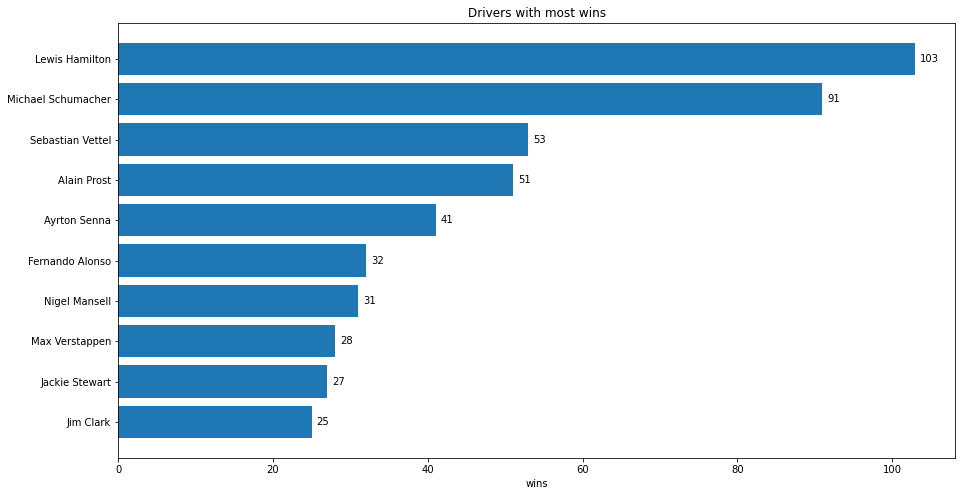

In [9]:
stats.horizontal_barplot(df=wins, rowcount=10, sort_value='race', sort_ascending=False, 
                         xcolumn='driver', ycolumn='race', invert_yaxis=True,
                         title='Drivers with most wins', 
                         xlabel='wins', ylabel='')

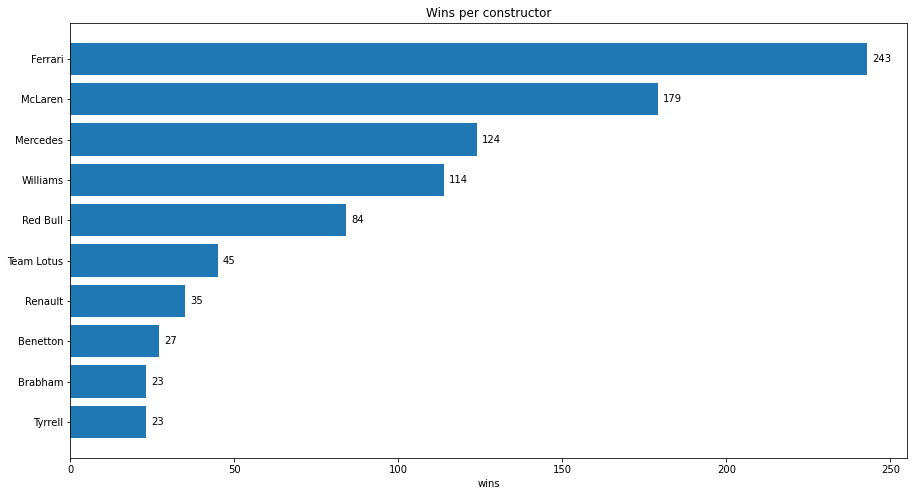

In [10]:
wins = winners[['constructor', 'race']].groupby('constructor').count().reset_index().sort_values('race', ascending=False)

stats.horizontal_barplot(df=wins, rowcount=10, sort_value='race', sort_ascending=False, 
                         xcolumn='constructor', ycolumn='race', invert_yaxis=True,
                         title='Wins per constructor', 
                         xlabel='wins', ylabel='')

In [11]:
df = winners[['constructor', 'driver', 'race']].groupby(['constructor', 'driver']).count(). \
            sort_values('constructor')
df[df.race >= 15].sort_values(['constructor', 'race'], ascending=False)

race
constructor  driver                  
Williams     Nigel Mansell         28
             Damon Hill            21
Tyrrell      Jackie Stewart        15
Renault      Fernando Alonso       17
Red Bull     Sebastian Vettel      38
             Max Verstappen        28
Mercedes     Lewis Hamilton        82
             Nico Rosberg          23
McLaren      Ayrton Senna          35
             Alain Prost           30
             Lewis Hamilton        21
             Mika Häkkinen         20
Lotus-Climax Jim Clark             19
Ferrari      Michael Schumacher    72
             Niki Lauda            15
Benetton     Michael Schumacher    19

# Drivers WDC standings over the season

In [12]:
year=2022
standings = stats.get_wdc_standing(year)
standings

,driverStandingsId,raceId,driverId,points,position,positionText,wins,year,round,race,name,code
288,71378,1074,1,15.0,3,3,0,2022,1,Bahrain Grand Prix,Lewis Hamilton,HAM
289,71274,1075,1,16.0,5,5,0,2022,2,Saudi Arabian Grand Prix,Lewis Hamilton,HAM
290,71294,1076,1,28.0,5,5,0,2022,3,Australian Grand Prix,Lewis Hamilton,HAM
291,71315,1077,1,28.0,7,7,0,2022,4,Emilia Romagna Grand Prix,Lewis Hamilton,HAM
292,71336,1078,1,36.0,6,6,0,2022,5,Miami Grand Prix,Lewis Hamilton,HAM
...,...,...,...,...,...,...,...,...,...,...,...,...
33681,71468,1082,855,5.0,16,16,0,2022,9,Canadian Grand Prix,Guanyu Zhou,ZHO
33682,71489,1083,855,5.0,16,16,0,2022,10,British Grand Prix,Guanyu Zhou,ZHO
33683,71510,1084,855,5.0,17,17,0,2022,11,Austrian Grand Prix,Guanyu Zhou,ZHO
33684,71531,1085,855,5.0,17,17,0,2022,12,French Grand Prix,Guanyu Zhou,ZHO


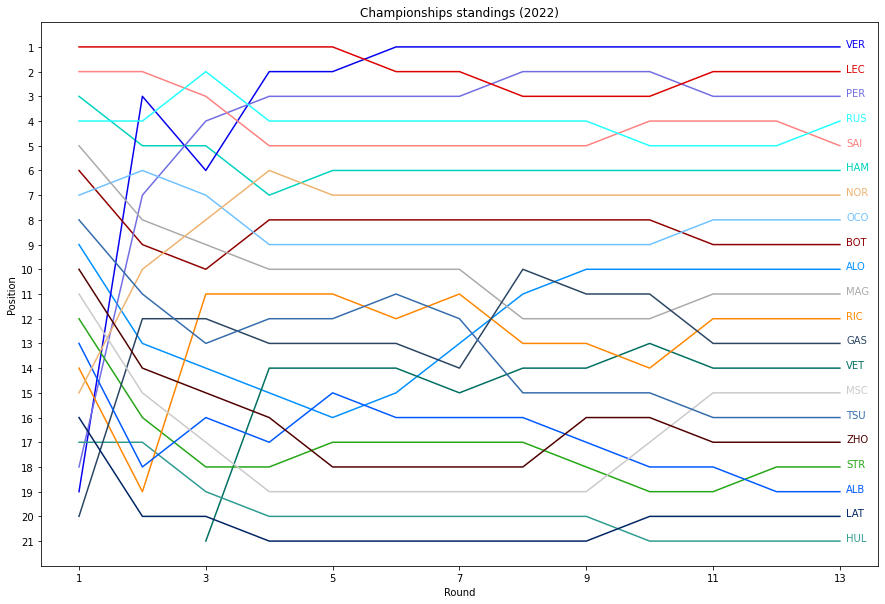

In [13]:
stats.horizontal_driver_lines_plot(df=standings, xcolumn='round', ycolumn='position', invert_yaxis=True,
                                   title='Championships standings ({})'.format(year),
                                   xlabel='Round', ylabel='Position')

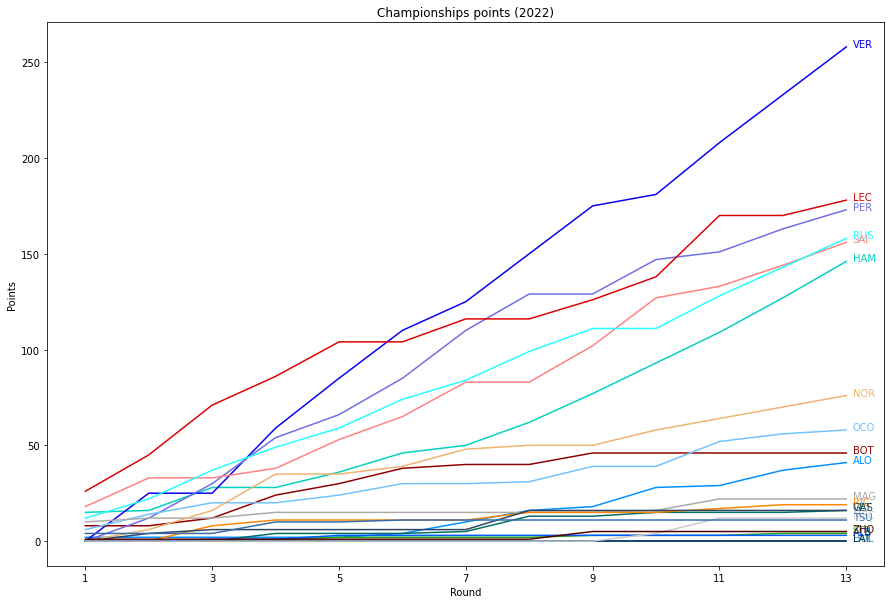

In [14]:
stats.horizontal_driver_lines_plot(df=standings, xcolumn='round', ycolumn='points', invert_yaxis=False,
                                   title='Championships points ({})'.format(year),
                                   xlabel='Round', ylabel='Points')

# Number of wins per champion

In [15]:
standings = stats.get_wdc_standing(None)

In [16]:
champions = stats.get_wdc_champions()
champions.sort_values('perc_win').head(10)

,year,round,position,driverId,name,code,points,wins,perc_win
32,1982,16,1,177,Keke Rosberg,,44.0,1,6.2
8,1958,11,1,578,Mike Hawthorn,,42.0,1,9.0
27,1977,17,1,182,Niki Lauda,,72.0,3,17.6
17,1967,11,1,304,Denny Hulme,,51.0,2,18.1
37,1987,16,1,137,Nelson Piquet,,73.0,3,18.7
33,1983,15,1,137,Nelson Piquet,,59.0,3,20.0
31,1981,15,1,137,Nelson Piquet,,50.0,3,20.0
29,1979,15,1,222,Jody Scheckter,,51.0,3,20.0
24,1974,15,1,224,Emerson Fittipaldi,,55.0,3,20.0
14,1964,10,1,341,John Surtees,,40.0,2,20.0


Text(0.5, 1.0, 'Number of races won by champion')

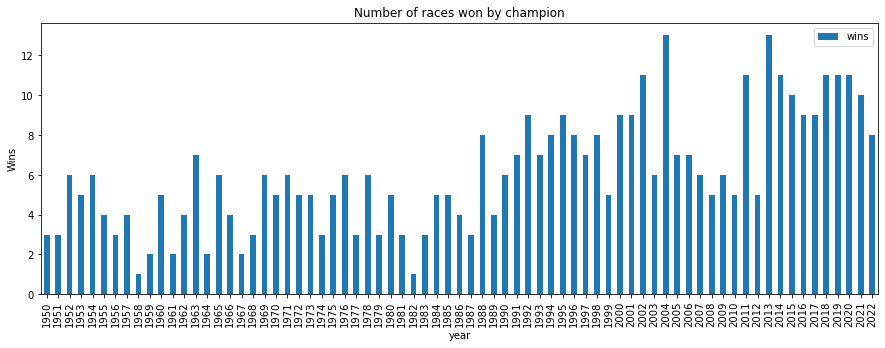

In [17]:
ax = champions.plot.bar('year', 'wins', figsize=(15,5))
ax.set_ylabel('Wins')
ax.set_title('Number of races won by champion')

Text(0.5, 1.0, 'Percentage races won by champion')

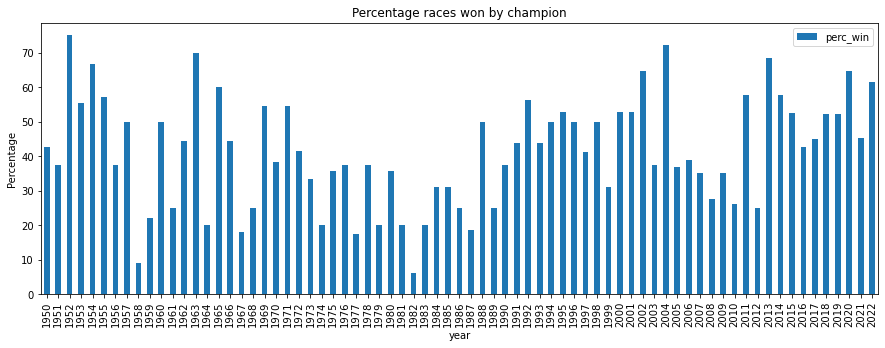

In [18]:
ax = champions.plot.bar('year', 'perc_win', figsize=(15,5))
ax.set_ylabel('Percentage')
ax.set_title('Percentage races won by champion')

# Most wins by drivers never being world champion

In [19]:
winners = stats.get_winners()
wins_per_driver = winners[['driverId', 'year']].groupby('driverId').count().reset_index(). \
                            rename(columns={"year": "podiums"})
champs = stats.get_wdc_champions()

In [20]:
not_champ = wins_per_driver[~wins_per_driver.driverId.isin(pd.unique(champs['driverId']))]
not_champ = not_champ.merge(stats.get_table('drivers'))[['driverId', 'name', 'podiums']]
not_champ = not_champ.sort_values('podiums', ascending=False)

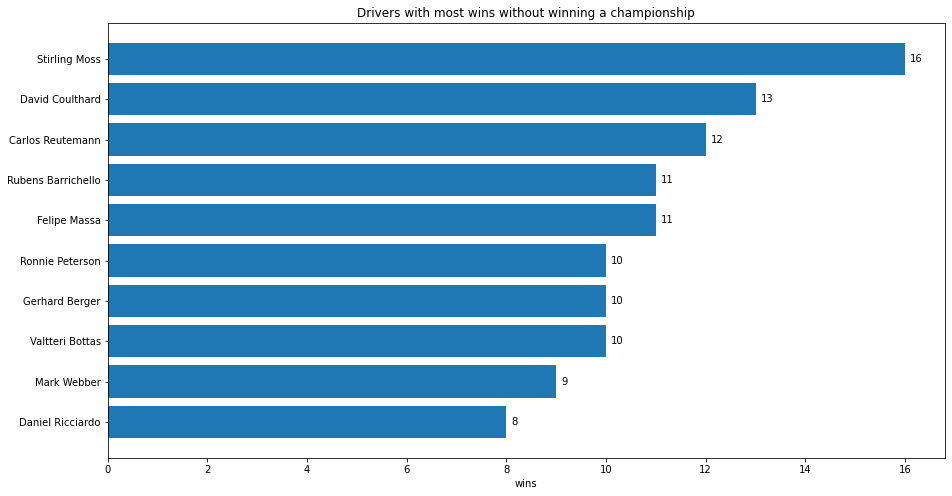

In [21]:
stats.horizontal_barplot(df=not_champ, rowcount=10, sort_value='podiums', sort_ascending=False, 
                         xcolumn='name', ycolumn='podiums', 
                         title='Drivers with most wins without winning a championship', 
                         xlabel='wins', ylabel='')

# Most podiums  without champion

In [22]:
podiums = stats.get_race_results()
podiums = podiums[podiums.position.between(1, 3)]
podiums_per_driver = podiums[['driverId', 'year']].groupby('driverId').count().reset_index(). \
                            rename(columns={"year": "podiums"})
champs = stats.get_wdc_champions()

In [23]:
not_champ = podiums_per_driver[~podiums_per_driver.driverId.isin(pd.unique(champs['driverId']))]
not_champ = not_champ.merge(stats.get_table('drivers'))[['driverId', 'name', 'podiums']]
not_champ = not_champ.sort_values('podiums', ascending=False)

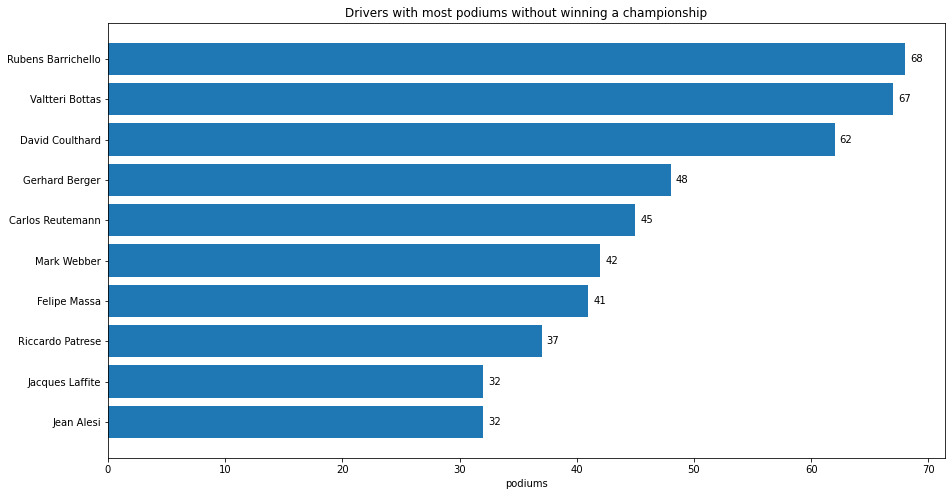

In [24]:
stats.horizontal_barplot(df=not_champ, rowcount=10, sort_value='podiums', sort_ascending=False, 
                         xcolumn='name', ycolumn='podiums', 
                         title='Drivers with most podiums without winning a championship', 
                         xlabel='podiums', ylabel='')

# Grandprix lap chart

In [25]:
year = 2022
event = "Hungarian"
laps = stats.get_laps_for_race(year, event)

C:\Users\Leo\AppData\Local\Temp\ipykernel_2636\835708588.py:260: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  laps = laps.append(grid)


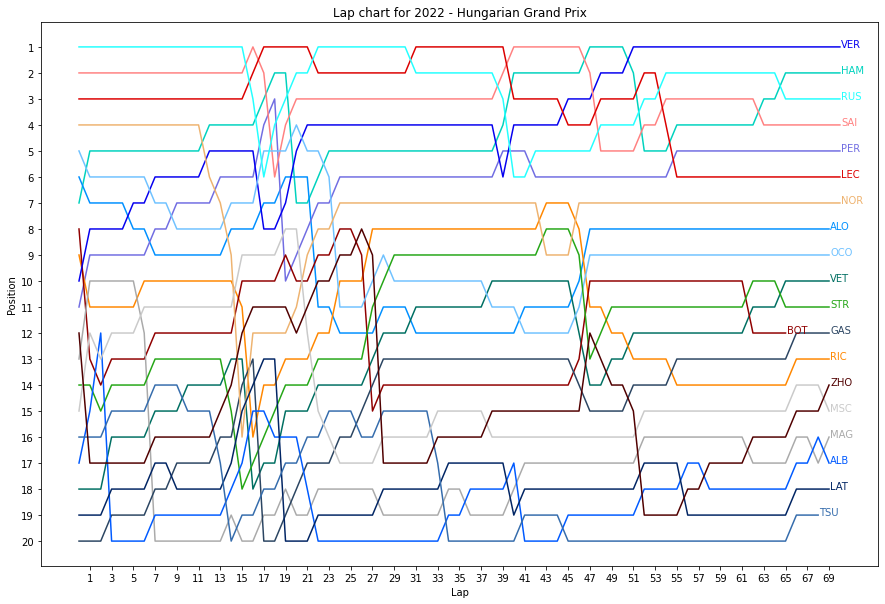

In [26]:
stats.horizontal_driver_lines_plot(df=laps, xcolumn='lap', ycolumn='position', invert_yaxis=True,
                                   title='Lap chart for {} - {}'.format(year, laps['event'].iloc[0]),
                                   xlabel='Lap', ylabel='Position')

# Compare points at a round with previous season

In [27]:
year=2022
nw = stats.get_wdc_standing(year)
rnd = nw['round'].max()
nw = nw[nw['round'] == rnd][['position', 'code', 'name', 'points']].sort_values('points', ascending=False)
pv = stats.get_wdc_standing(year-1)
pv = pv[pv['round'] == rnd][['code', 'points']].sort_values('points', ascending=False)
pv = pv.rename(columns={"points": "prev_year"})
comp = pd.merge(nw, pv, on='code')
comp['diff'] = comp['points'] - comp['prev_year']
comp['color'] = 'green'
comp.loc[comp['diff'] < 0, 'color'] = 'red'

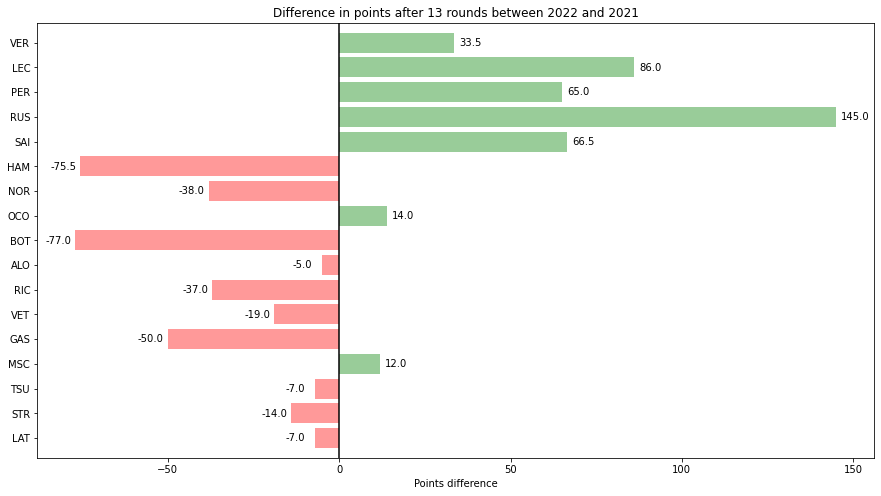

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
 
# Plotting the horizontal lines
rects = ax.hlines(y=comp.code, xmin=0, xmax=comp['diff'], color=comp['color'], alpha=0.4, linewidth=20)
ax.invert_yaxis()

for nm, vl in zip(comp.code, comp['diff']):
    label = ax.annotate(str(vl), xy=(vl, nm), xytext=(5 if vl > 0 else -30, 0),
                        textcoords="offset points",
                        ha="left", va='center')
ax.axvline(0, color='black')
ax.set_title('Difference in points after {} rounds between {} and {}'.format(rnd, year, year-1))
_ = ax.set_xlabel('Points difference')

In [29]:
year=2022
nw = stats.get_wcc_standing(year)
rnd = nw['round'].max()
nw = nw[nw['round'] == rnd][['position', 'name', 'points']].sort_values('points', ascending=False)
pv = stats.get_wcc_standing(year-1)
pv = pv[pv['round'] == rnd][['name', 'points']].sort_values('points', ascending=False)
pv = pv.rename(columns={"points": "prev_year"})
comp = pd.merge(nw, pv, on='name')
comp['diff'] = comp['points'] - comp['prev_year']
comp['color'] = 'green'
comp.loc[comp['diff'] < 0, 'color'] = 'red'

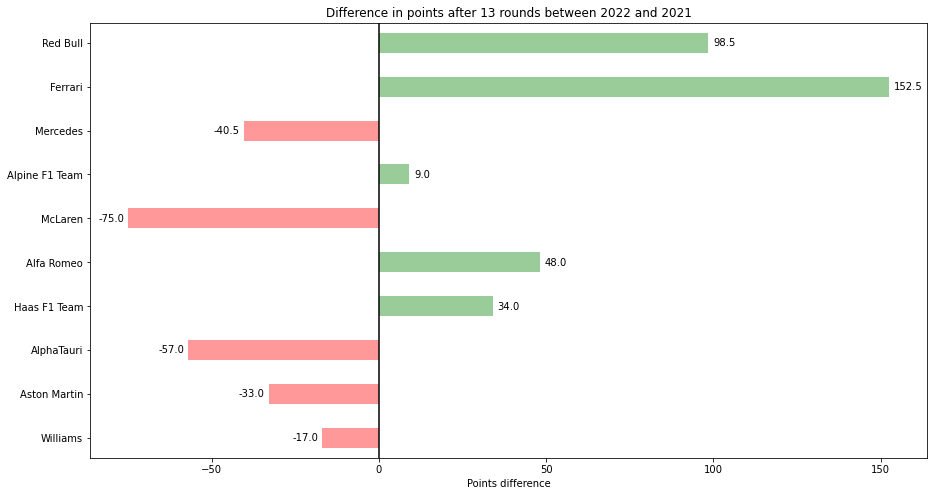

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
 
# Plotting the horizontal lines
rects = ax.hlines(y=comp.name, xmin=0, xmax=comp['diff'], color=comp['color'], alpha=0.4, linewidth=20)
ax.invert_yaxis()

for nm, vl in zip(comp.name, comp['diff']):
    label = ax.annotate(str(vl), xy=(vl, nm), xytext=(5 if vl > 0 else -30, 0),
                        textcoords="offset points",
                        ha="left", va='center')
ax.axvline(0, color='black')
ax.set_title('Difference in points after {} rounds between {} and {}'.format(rnd, year, year-1))
_ = ax.set_xlabel('Points difference')

# Pole positions and pole+wins per driver

In [31]:
winners = stats.get_winners()
poles = stats.get_pole_sitters()

pandw = pd.merge(winners.add_prefix('win_'), poles.add_prefix('pole_'), left_on='win_raceId', right_on='pole_raceId')
pandw = pandw[['win_raceId', 'win_year', 'win_round', 'win_driverId', 'win_driver', 'pole_driverId', 'pole_driver']]
pandw['pole_and_win'] = (pandw['win_driverId'] == pandw['pole_driverId'])

In [32]:
pw = pandw[pandw.pole_and_win][['pole_driver', 'pole_driverId', 'win_raceId']].groupby(['pole_driver', 'pole_driverId']).count().reset_index().rename(columns={'win_raceId' : 'poles_and_wins'})
w = pandw[['pole_driver', 'pole_driverId', 'win_raceId']].groupby(['pole_driver', 'pole_driverId']).count().reset_index().rename(columns={'win_raceId' : 'poles'})
res = pd.merge(w, pw, on = 'pole_driverId').drop(columns=['pole_driver_y'])[['pole_driver_x', 'poles', 'poles_and_wins']]
res = res.rename(columns={'pole_driver_x': 'pole_driver'}).sort_values('poles', ascending=False)
res.head(10)

,pole_driver,poles,poles_and_wins
14,Lewis Hamilton,106,62
23,Sebastian Vettel,57,31
17,Michael Schumacher,36,24
19,Nico Rosberg,30,15
6,Fernando Alonso,23,14
24,Valtteri Bottas,19,5
13,Kimi Räikkönen,19,6
5,Felipe Massa,16,8
16,Max Verstappen,15,11
1,Charles Leclerc,15,4


# Average finishing position

In [33]:
year = 2022
results = stats.get_race_results()
results = results[results['year'] == year]
# DNF equals position 20
results.loc[results['position'] == 0, 'position'] = 20
#results = results[results['position'] > 0]
results[['driver', 'position']].groupby('driver').mean().sort_values('position')

,position
driver,
Max Verstappen,4.538462
George Russell,5.076923
Lewis Hamilton,5.076923
Sergio Pérez,6.615385
Charles Leclerc,7.076923
Carlos Sainz,8.153846
Lando Norris,8.846154
Esteban Ocon,9.153846
Fernando Alonso,10.615385


# Places gained and lost

In [34]:
year = 2022
rnd = 13
pgl = stats.get_race_results(year)
pgl = pgl[pgl['round'] == rnd][['driver', 'grid', 'position']]
pgl['change'] = pgl['grid'] - pgl['position']

def _color_red_or_green(val):
    color = 'orangered' if val < 0 else 'springgreen'
    return 'background-color: %s' % color
pgl.style.applymap(_color_red_or_green, subset=['change'])

,driver,grid,position,change
12059,Max Verstappen,10,1,9
2003,Lewis Hamilton,7,2,5
2354,George Russell,1,3,-2
9230,Carlos Sainz,2,4,-2
11805,Sergio Pérez,11,5,6
9303,Charles Leclerc,3,6,-3
1812,Lando Norris,4,7,-3
9338,Fernando Alonso,6,8,-2
9373,Esteban Ocon,5,9,-4
13464,Sebastian Vettel,18,10,8


# Average age of drivers per year

In [35]:
raceresults = \
    pd.merge(
             pd.merge(pd.merge(stats.dfs['results'][['resultId', 'raceId', 'driverId', 'constructorId', 
                                                    'grid','position']], 
                               stats.dfs['races'][['raceId', 'year', 'round', 'name', 'date']]. \
                                       rename(columns={'name': 'race'})),
                      stats.dfs['drivers'][['driverId', 'number', 'name', 'dob']]. \
                              rename(columns={'name': 'driver'})),
             stats.dfs['constructors'][['constructorId', 'name']].rename(columns={'name': 'constructor'})
            )
raceresults = raceresults.sort_values(['year', 'round', 'position'])
raceresults['age'] = (pd.to_datetime(raceresults['date']).dt.date - raceresults['dob']) / np.timedelta64(1, 'Y')
avg_age = raceresults[['year', 'age']].groupby('year').mean()

Text(0.5, 0, 'year')

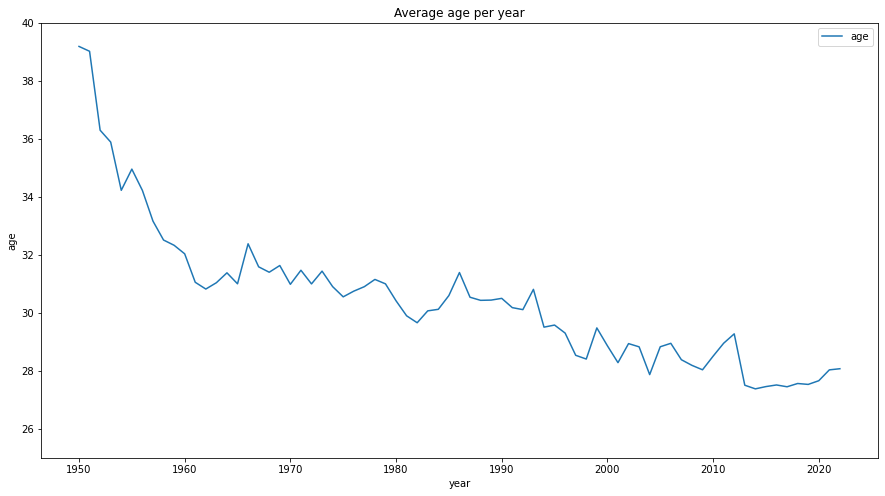

In [36]:
fig, ax = plt.subplots(figsize=(15,8))

avg_age.plot(ax=ax)
ax.set_ylim(25,40)
ax.set_title('Average age per year')
ax.set_ylabel('age')
ax.set_xlabel('year')

# World champion with most DNF's

In [37]:
dnfs = stats.get_dnfs()
dnfs = dnfs[['year', 'driverId', 'position']].groupby(['year', 'driverId']).count(). \
                                              reset_index().rename(columns={'position':'dnfs'})

champs = stats.get_wdc_champions()
champs = champs.merge(dnfs, on=['year', 'driverId'], how='left').fillna(0)
champs['dnf_perc'] = (champs['dnfs'] / champs['round'] * 1000).astype(int) / 10

champs[['year', 'name', 'wins', 'dnfs', 'dnf_perc']].sort_values('dnfs', ascending = False).head(10)

,year,name,wins,dnfs,dnf_perc
34,1984,Niki Lauda,5,6.0,37.5
47,1997,Jacques Villeneuve,7,6.0,35.2
26,1976,James Hunt,6,6.0,37.5
49,1999,Mika Häkkinen,5,5.0,31.2
28,1978,Mario Andretti,6,4.0,25.0
31,1981,Nelson Piquet,3,4.0,26.6
33,1983,Nelson Piquet,3,4.0,26.6
35,1985,Alain Prost,5,4.0,25.0
14,1964,John Surtees,2,4.0,40.0
20,1970,Jochen Rindt,5,4.0,30.7


# Head to Head

In [38]:
year = 2022
driver1 = 'VER'
driver2 = 'PER'

In [39]:
race_results = stats.get_race_results()
race_results = race_results[race_results['year'] == year]

dr = [ race_results[race_results.code == driver1]['driverId'].values[0],
       race_results[race_results.code == driver2]['driverId'].values[0] ]

In [40]:
race_results['position'] = race_results['position'].replace(0, 30)
race=[0, 0, 10]
for rid in race_results.raceId.unique():
    pos1 = race_results.loc[(race_results.raceId == rid) & (race_results.driverId == dr[0]), 'position'].values[0]
    pos2 = race_results.loc[(race_results.raceId == rid) & (race_results.driverId == dr[1]), 'position'].values[0]
    if pos1 < pos2:
        race[0] += 1
    elif pos2 < pos1:
        race[1] += 1

In [41]:
quali_results = stats.get_quali_results()
quali_results = quali_results[quali_results['year'] == year]
quali=[0, 0, 10]
for rid in quali_results.raceId.unique():
    pos1 = quali_results.loc[(quali_results.raceId == rid) & (quali_results.driverId == dr[0]), 'position'].values[0]
    pos2 = quali_results.loc[(quali_results.raceId == rid) & (quali_results.driverId == dr[1]), 'position'].values[0]
    if pos1 < pos2:
        quali[0] += 1
    elif pos2 < pos1:
        quali[1] += 1

In [42]:
standings = stats.get_wdc_standing()
standings = standings[(standings['year'] == year)]
standings = standings[(standings['round'] == standings['round'].max())]
pnts = [ standings.loc[standings.driverId == dr[0], 'points'].values[0],
         standings.loc[standings.driverId == dr[1], 'points'].values[0]  ]

In [43]:
bpos = [ race_results.loc[race_results['driverId'] == dr[0], 'position'].min(),
         race_results.loc[race_results['driverId'] == dr[1], 'position'].min(), 10 ]

In [44]:
bgr  = [ race_results.loc[race_results['driverId'] == dr[0], 'grid'].min(),
         race_results.loc[race_results['driverId'] == dr[1], 'grid'].min(), 10 ]

In [45]:
dnfs = stats.get_dnfs()
dnfs = dnfs[dnfs['year'] == year]
dnf = [ len(dnfs[dnfs.driverId == dr[0]]), 
        len(dnfs[dnfs.driverId == dr[1]]), 10 ]

In [46]:
wins = [ len(race_results.loc[(race_results['driverId'] == dr[0]) & (race_results['position'] == 1), 'position']),
         len(race_results.loc[(race_results['driverId'] == dr[1]) & (race_results['position'] == 1), 'position']), 10 ]

podia = [ len(race_results.loc[(race_results['driverId'] == dr[0]) & (race_results['position'] <= 3), 'position']),
          len(race_results.loc[(race_results['driverId'] == dr[1]) & (race_results['position'] <= 3), 'position']), 10 ]

In [47]:
print('Driver         : {}   {}'.format(driver1, driver2))
print('Driver IDs     : {:3d}   {:3d}'.format(dr[0], dr[1]))
print('Race           : {:3d}   {:3d}'.format(race[0], race[1]))
print('Qualifying     : {:3d}   {:3d}'.format(quali[0], quali[1]))
print('Points         : {:3.0f}   {:3.0f}'.format(pnts[0], pnts[1]))
print('Best finsish   : {:3d}   {:3d}'.format(bpos[0], bpos[1]))
print('Best grid      : {:3d}   {:3d}'.format(bgr[0], bgr[1]))
print('DNFs           : {:3d}   {:3d}'.format(dnf[0], dnf[1]))
print('Wins           : {:3d}   {:3d}'.format(wins[0], wins[1]))
print('Podiums        : {:3d}   {:3d}'.format(podia[0], podia[1]))

Driver         : VER   PER
Driver IDs     : 830   815
Race           :   9     4
Qualifying     :  10     3
Points         : 258   173
Best finsish   :   1     1
Best grid      :   1     1
DNFs           :   1     2
Wins           :   8     1
Podiums        :  10     6


Text(0.5, 1.0, 'Comparison VER to PER')

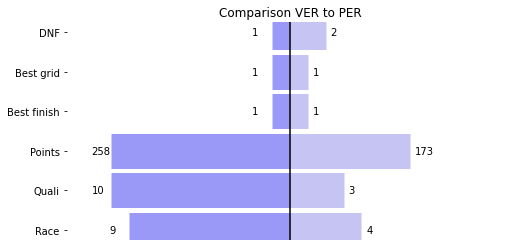

In [48]:
fig, ax = plt.subplots(figsize=(8,4))

driver_clrs = [stats.get_driver_color(dr[0]), stats.get_driver_color(dr[1]) ]

ys    = ['Race', 'Race',
         'Quali', 'Quali',
         'Points', 'Points', 
         'Best finish', 'Best finish', 
         'Best grid', 'Best grid', 
         'DNF', 'DNF']
xmaxs = [-race[0]/max(race), race[1]/max(race), \
         -quali[0]/max(quali), quali[1]/max(quali), \
         -pnts[0]/max(pnts), pnts[1]/max(pnts), \
         -bpos[0]/max(bpos), bpos[1]/max(bpos), \
         -bgr[0]/max(bgr), bgr[1]/max(bgr), \
         -dnf[0]/max(dnf), dnf[1]/max(dnf)]
labels = [race[0], race[1], \
          quali[0], quali[1], \
          pnts[0], pnts[1], \
          bpos[0], bpos[1], \
          bgr[0], bgr[1], \
          dnf[0], dnf[1]]
clrs  = np.tile([driver_clrs[0], driver_clrs[1]], 6) 

rects = ax.hlines(y=ys, xmin=0, xmax=xmaxs, color=clrs, alpha=0.4, linewidth=35)
for nm, lbl, vl in zip(ys, labels, xmaxs):
    label = ax.annotate(str(int(lbl)), xy=(vl, nm), xytext=(5 if vl > 0 else -20, 0),
                        textcoords="offset points",
                        ha="left", va='center')

ax.set_xlim(-1.25, 1.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axvline(0, color='black')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_title('Comparison {} to {}'.format(driver1, driver2))

In [49]:
wins

[8, 1, 10]

Text(0.5, 1.0, 'Comparison VER to PER')

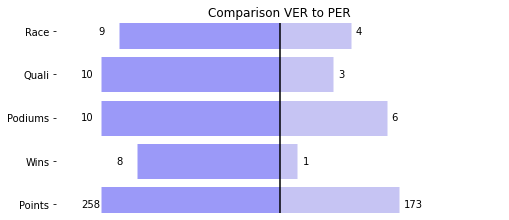

In [50]:
fig, ax = plt.subplots(figsize=(8,3.5))

driver_clrs = [stats.get_driver_color(dr[0]), stats.get_driver_color(dr[1]) ]

ys    = ['Points', 'Points', 
         'Wins', 'Wins', 
         'Podiums', 'Podiums', 
         'Quali', 'Quali', 
         'Race', 'Race']
xmaxs = [-pnts[0]/max(pnts), pnts[1]/max(pnts), \
         -wins[0]/max(wins), wins[1]/max(wins), \
         -podia[0]/max(podia), podia[1]/max(podia), \
         -quali[0]/max(quali), quali[1]/max(quali), \
         -race[0]/max(race), race[1]/max(race)]
labels = [pnts[0], pnts[1], \
          wins[0], wins[1], \
          podia[0], podia[1], \
          quali[0], quali[1], \
          race[0], race[1]]
clrs  = np.tile([driver_clrs[0], driver_clrs[1]], 5) 

rects = ax.hlines(y=ys, xmin=0, xmax=xmaxs, color=clrs, alpha=0.4, linewidth=35)
for nm, lbl, vl in zip(ys, labels, xmaxs):
    label = ax.annotate(str(int(lbl)), xy=(vl, nm), xytext=(5 if vl > 0 else -20, 0),
                        textcoords="offset points",
                        ha="left", va='center')

ax.set_xlim(-1.25, 1.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axvline(0, color='black')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_title('Comparison {} to {}'.format(driver1, driver2))

# Compare lap times

In [51]:
season = 2022
rnd = 13
driver1 = 'VER'
driver2 = 'LEC'
laps = stats.get_laps_for_race(season, rnd)
laps = laps[laps['code'].isin([driver1, driver2])]
laps['milliseconds'] = laps['milliseconds'].div(1000)

C:\Users\Leo\AppData\Local\Temp\ipykernel_2636\835708588.py:260: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  laps = laps.append(grid)


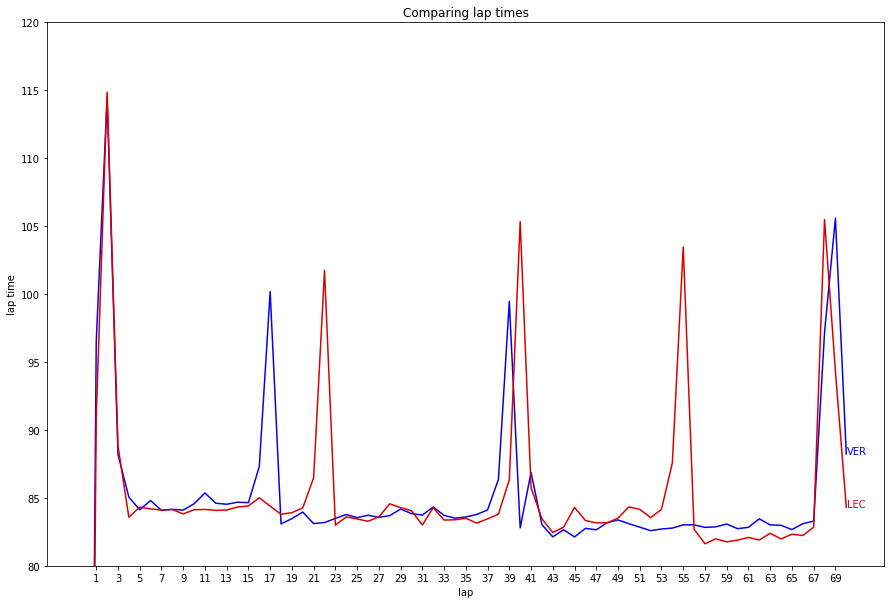

In [52]:
stats.horizontal_driver_lines_plot(df=laps, xcolumn='lap', ycolumn='milliseconds', invert_yaxis=False, ymin=80, ymax=120, 
                                   title='Comparing lap times', xlabel='lap', ylabel='lap time')

# Most dominated seasons

In [53]:
rnd = 13

results = stats.get_race_results()
results

points = [0, 25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
results['points'] = results['position'].apply(lambda x: points[x])
results = results[results['round'] <= rnd]
results = results[['year', 'driverId', 'driver', 'constructor', 'points']]. \
                 groupby(['year', 'driverId', 'driver', 'constructor']).sum().reset_index()
results['points'] = results['points'].div(rnd)
results = results.set_index('year').sort_values('points', ascending=False).groupby('year').nth(0). \
                  sort_values('points', ascending=False).reset_index()
results['desc'] = results['year'].astype(str) + ' ' + results['driver']
results

,year,driverId,driver,constructor,points,desc
0,2004,30,Michael Schumacher,Ferrari,23.076923,2004 Michael Schumacher
1,2002,30,Michael Schumacher,Ferrari,22.615385,2002 Michael Schumacher
2,2011,20,Sebastian Vettel,Red Bull,21.846154,2011 Sebastian Vettel
3,2020,1,Lewis Hamilton,Mercedes,21.230769,2020 Lewis Hamilton
4,2019,1,Lewis Hamilton,Mercedes,20.461538,2019 Lewis Hamilton
...,...,...,...,...,...,...
68,1961,403,Phil Hill,Ferrari,9.076923,1961 Phil Hill
69,1955,579,Juan Fangio,Mercedes,9.076923,1955 Juan Fangio
70,1951,579,Juan Fangio,Alfa Romeo,8.692308,1951 Juan Fangio
71,1959,356,Jack Brabham,Cooper-Climax,8.461538,1959 Jack Brabham


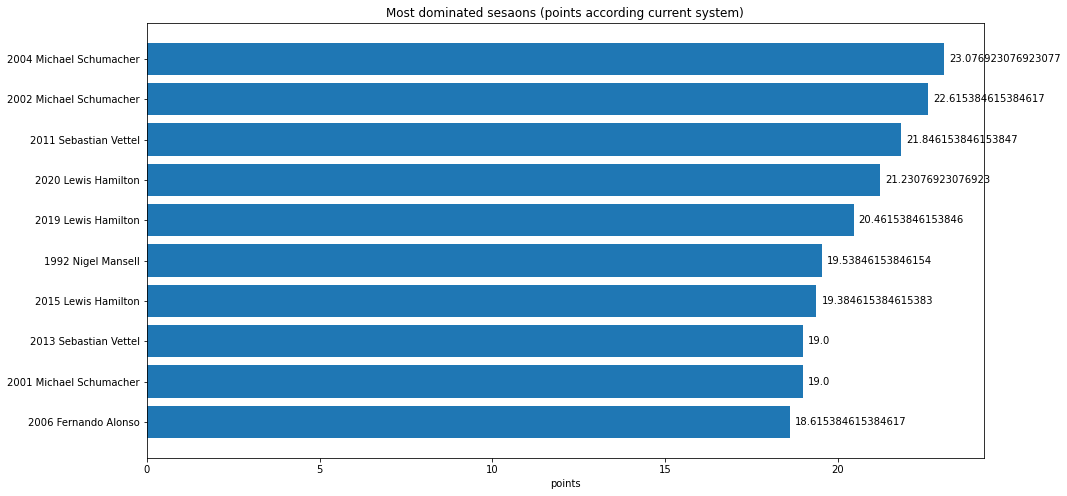

In [54]:
stats.horizontal_barplot(df=results, rowcount=10, sort_value='points', sort_ascending=False, 
                         ycolumn='points', xcolumn='desc', 
                         title='Most dominated sesaons (points according current system)', 
                         xlabel='points', ylabel='')

# Most laps led since 2020

In [55]:
year = 2020

races = stats.dfs['races']
races = races[races['year'] >= year]
raceids = races['raceId'].values

laps_led = stats.dfs['lap_times']
laps_led = laps_led[laps_led['raceId'].isin(raceids)]
laps_led = laps_led[['driverId', 'lap']].groupby('driverId').count().reset_index()
laps_led = laps_led.merge(stats.dfs['drivers'][['driverId', 'code', 'name']])
laps_led

,driverId,lap,code,name
0,1,3000,HAM,Lewis Hamilton
1,4,1963,ALO,Fernando Alonso
2,8,2070,RAI,Kimi Räikkönen
3,9,123,KUB,Robert Kubica
4,20,2810,VET,Sebastian Vettel
5,154,800,GRO,Romain Grosjean
6,807,219,HUL,Nico Hülkenberg
7,815,2736,PER,Sergio Pérez
8,817,3009,RIC,Daniel Ricciardo
9,822,2857,BOT,Valtteri Bottas


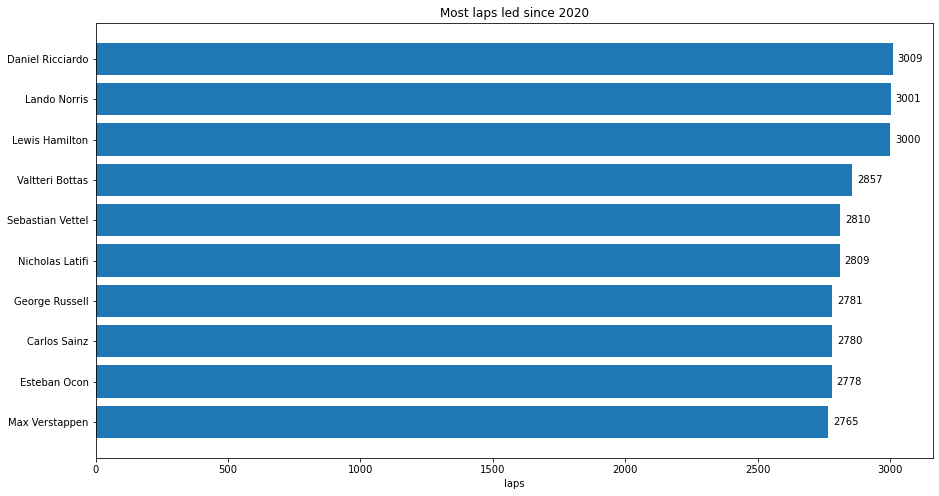

In [56]:
stats.horizontal_barplot(df=laps_led, rowcount=10, sort_value='lap', sort_ascending=False, 
                         xcolumn='name', ycolumn='lap', title='Most laps led since {}'.format(year), 
                         xlabel = 'laps', ylabel='', invert_yaxis=True)

# Points scored in last 6 rounds

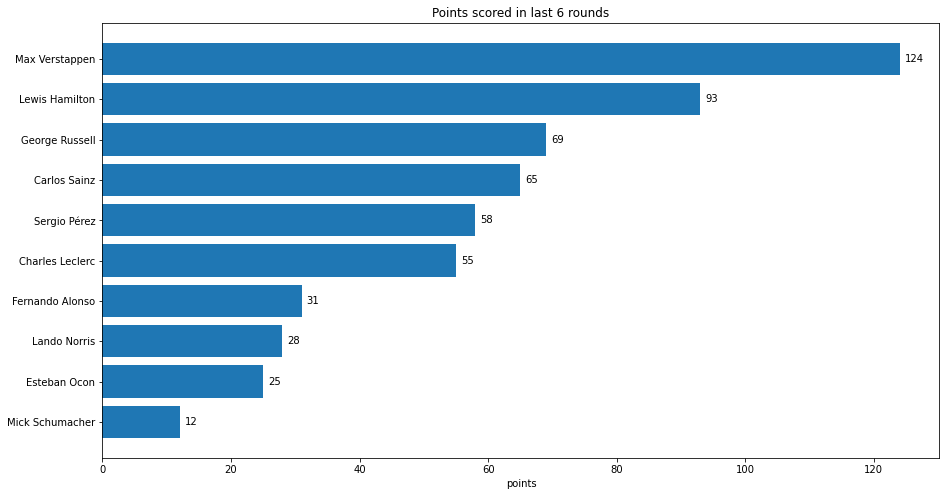

In [57]:
results = stats.get_race_results()
results = results[results['year'] == results['year'].max()]
results = results[(results['round'] <= results['round'].max()) & (results['round'] > results['round'].max()-6)]
results = results[['driver', 'code', 'points']].groupby(['driver', 'code']).sum().reset_index(). \
              rename(columns={'driver' : 'name'}).sort_values('points', ascending=False)

stats.horizontal_barplot(df=results, rowcount=10, sort_value='points', sort_ascending=False, 
                         xcolumn='name', ycolumn='points', title='Points scored in last 6 rounds', 
                         xlabel = 'points', ylabel='', invert_yaxis=True)

# Experience of current drivers

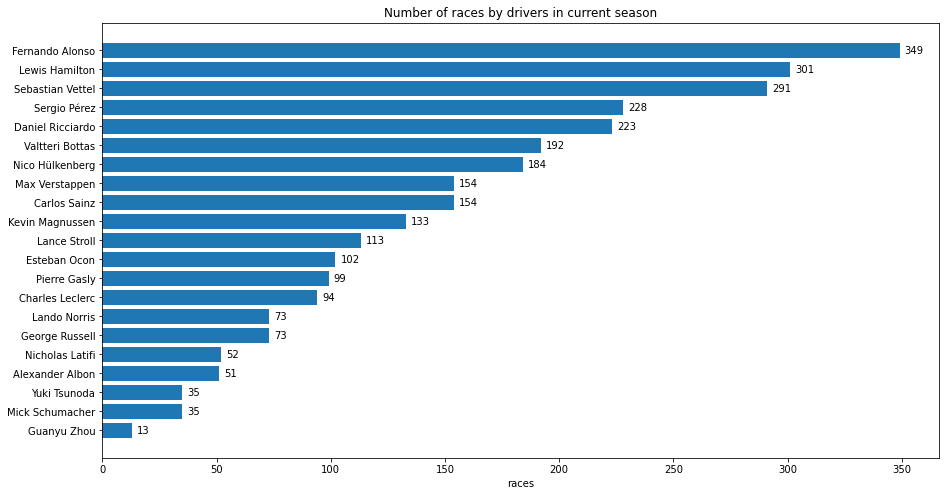

In [58]:
results = stats.get_race_results()
current_driver_ids = results[results['year'] == 2022]['driverId']

current_drivers = results[results['driverId'].isin(pd.unique(current_driver_ids))]
current_drivers = current_drivers[['driverId', 'driver', 'race']]. \
                      groupby(['driverId', 'driver']).count().reset_index()

stats.horizontal_barplot(df=current_drivers, rowcount=30, sort_value='race', 
                         sort_ascending=False, invert_yaxis=True, 
                         xcolumn='driver', ycolumn='race', 
                         title='Number of races by drivers in current season', 
                         xlabel = 'races', ylabel='')

Text(0.5, 1.0, 'Driver experience over the years')

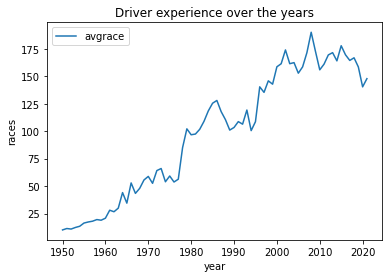

In [59]:
results = stats.get_race_results()
year_avgrace=[]
for year in range(1950, 2022):
    current_driver_ids = results[results['year'] == year]['driverId']

    current_drivers = results[results['driverId'].isin(pd.unique(current_driver_ids))]
    current_drivers = current_drivers[['driverId', 'driver', 'race']]. \
                          groupby(['driverId', 'driver']).count().reset_index()['race'].mean()
    #print('{} : {:3.1f}'.format(year, current_drivers))
    year_avgrace.append({'year': year, 'avgrace': current_drivers})
ax = pd.DataFrame(year_avgrace).plot('year', 'avgrace')
ax.set_ylabel('races')
ax.set_title('Driver experience over the years')